In [517]:
import json
import numpy as np
import torch


# Split episodes

In [503]:
dataset = 'dataset_eps0.0.jsonl'

data = []

with open(dataset, 'r') as f:
    for d in f.readlines():
        data.append(json.loads(d))

X, y = zip(*
    [(r['observation'], r['next_observation']) for episode in data for r in episode
    if r['next_observation'] != None]
)
X = torch.tensor(X)
y = torch.tensor(y)

In [504]:
print(X.shape)
print(y.shape)

torch.Size([158408, 6])
torch.Size([158408, 6])


In [505]:
# means = torch.mean(X, axis=0)
# stdevs = torch.std(X, axis=0)
# print(means, stdevs)

In [127]:
# X = (X - means)/ stdevs
# y = (y - means)/ stdevs

In [506]:
def fit_model(X, y):
    rbf_kernel = ConstantKernel(1.0) * RBF(length_scale=1.0)
    gp = GaussianProcessRegressor(kernel=rbf_kernel, random_state=0, n_restarts_optimizer=10)

    gpr = gp.fit(X, y)
#     predictions = gpr.predict(X[:2,:], return_std=True)
#   r_square = gpr.score(X, y)

    return gpr

def normalize(X, y):
    means = torch.mean(X, axis=0)
    stdevs = torch.std(X, axis=0)
    X = (X - means)/ stdevs
    y = (y - means)/ stdevs
    return X, y

def split_data(X, y, ratio=(0.6, 0.3)):
    """
    Splits an episode.
    """
    
    assert sum(ratio) < 1., 'Ratio arg invalid. You need to define a split to allow for test samples.'
    
    num_samples = X.shape[0]
    indices = torch.randperm(X.shape[0])
    tr_idx = int(num_samples*ratio[0])
    dev_idx = int(num_samples*ratio[1])
    print(f'Training id and dev id: {tr_idx}, {dev_idx}')
    
    training_X = X[indices[:tr_idx]]
    training_y = y[indices[:tr_idx]]
    dev_X = X[indices[tr_idx:tr_idx+dev_idx]]
    dev_y = y[indices[tr_idx:tr_idx+dev_idx]]
    test_X = X[indices[tr_idx+dev_idx:]]
    test_y = y[indices[tr_idx+dev_idx:]]
    
    print(f'Created {len(training_X)} training, {len(dev_X)}, dev and {len(test_X)} test samples')
    
    return (
        (training_X, training_y),
        (dev_X, dev_y),
        (test_X, test_y)
    )
    
    
def split_by_episodes(data, ratio=(0.6, 0.3)):
    """
    Splits by episodes
    """
    
    assert sum(ratio) < 1., 'Ratio arg invalid. You need to define a split to allow for test samples.'
    
    num_samples = len(data)
    indices = torch.randperm(num_samples)
    
    tr_idx = int(num_samples*ratio[0])
    dev_idx = int(num_samples*ratio[1])
    print(f'Training id and dev id: {tr_idx}, {dev_idx}')
    
    training = data[indices[:tr_idx]]
    dev = data[indices[tr_idx:tr_idx+dev_idx]]
    test = data[indices[tr_idx+dev_idx:]]
    
    print(f'Created {len(training)} training, {len(dev)} dev and {len(test)} test samples')
    
    return ( 
        training, dev, test
    )


In [507]:
X, y = normalize(X, y)
tr, dev, test = split_data(X, y, ratio=(0.6, 0.3))

Training id and dev id: 95044, 47522
Created 95044 training, 47522, dev and 15842 test samples


In [70]:
# # gpr = fit_model(*tr)

# # # Compute posterior mean and covariance
# # predicted_mus, predicted_cov = gpr.predict(test[0], return_cov=True)


# # # Obtain optimized kernel parameters
# # l = gpr.kernel_.k2.get_params()['length_scale']
# # sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

# # # # Compare with previous results
# # # assert(np.isclose(l_opt, l))
# # # assert(np.isclose(sigma_f_opt, sigma_f))

# mse = ((predicted_mus - test[1])**2).mean()
# mse
# predicted_mus.shape
# gpr.log_marginal_likelihood()

# import numpy as np
# import matplotlib.pyplot as plt

# from matplotlib import animation, cm
# from mpl_toolkits.mplot3d import Axes3D


# def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
#     X = X.ravel()
#     mu = mu.ravel()
#     uncertainty = 1.96 * np.sqrt(np.diag(cov))
#     print(mu.shape)
    
#     plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
#     plt.plot(X, mu, label='Mean')
#     for i, sample in enumerate(samples):
#         plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
#     if X_train is not None:
#         plt.plot(X_train, Y_train, 'rx')
#     plt.legend()
    
# # Plot the results
# plot_gp(predicted_mus, predicted_cov, X=np.ones(test[0].shape), X_train=test[0], Y_train=test[1])

0.01

In [508]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(
            self,
            state_dim=6,
            device='cuda'
    ):
        super(Model, self).__init__()
        self.model = nn.Linear(state_dim, state_dim)
        self.device= device

    def forward(self, state):
        next_state = self.model(state)
        return next_state
    
    def save(self, optimizer, filename):
        torch.save(self.model.state_dict(), filename)
        torch.save(optimizer.state_dict(), filename)

    def load(self, optimizer, filename):
        self.model.load_state_dict(torch.load(filename))
        optimizer.load_state_dict(torch.load(filename))

    
    
class Trainer():
    def __init__(self, state_dim=6, eta=1e-3, epochs=10, batch_size=128):
        self.eta = eta
        self.epochs = epochs
        self.batch_size=batch_size
        self.model = Model(state_dim=state_dim)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.eta)

    def prepare_data(self, episode_data):
        X, y = zip(*
            [(r['observation'], r['next_observation']) for r in episode_data if r['next_observation'] != None]
        )
        X = torch.tensor(X)
        y = torch.tensor(y)        
        X, y = normalize(X, y)
        batches = []
        num_batches = X.shape[0] // self.batch_size
        for batch in range(num_batches):
            
            batch = (
                X[batch*self.batch_size: (batch+1)*self.batch_size],
                y[batch*self.batch_size: (batch+1)*self.batch_size]
            )
            batches.append(batch)
        
        return batches
        
    def eval_on_dev(self, dev):
        self.model.eval()
        dev_losses = 0
        counter = 0
        
        for episode in range(len(dev)):
            batches = self.prepare_data(dev[episode])
            
            for b in batches:
                states, next_states = b[0], b[1]
                pred_next_states = self.model(states)
                curr_loss = F.mse_loss(pred_next_states, next_states)
                dev_losses += curr_loss.item()
                counter += states.shape[0]
            
        self.model.train()
        return dev_losses / counter
        
        
    def train(self, tr_data, dev_data, save_path='test_save_path'):
        
        epoch_losses = []
        val_losses = []
        
        for e in range(self.epochs):    
            epoch_loss = 0
            counter = 0
            
            for episode in range(len(tr_data)):
                curr_data = self.prepare_data(tr_data[episode])
                
                num_batches = len(curr_data)
                for idx in range(num_batches):

                    # actual trajectory
                    states, next_states = curr_data[idx][0], curr_data[idx][1]
                    
                    pred_next_states = self.model(states)
                    curr_loss = F.mse_loss(pred_next_states, next_states)
                    
                    self.optimizer.zero_grad()
                    curr_loss.backward()
                    self.optimizer.step()
                    epoch_loss += curr_loss
                    counter += states.shape[0]
                    
            epoch_losses.append(epoch_loss / counter)
                          
            # import ipdb;ipdb.set_trace()
            
            print(f'Epoch {e} training MSE: {epoch_losses[-1]}')
            val_loss = self.eval_on_dev(dev)
            print(f'Epoch {e} validation MSE: {val_loss}')
            val_losses.append(val_loss)
            
#             # save model
#             if save_path:
#                 self.model.save(f"{save_path}/model_at_epoch_{e}", self.optimizer)

        return epoch_losses, val_losses

    def predict(self, episode_data, state_ids=[0, 1]):
        """
        episode_data: tensor of timestamps x 6 states
        """
        results = []
        curr_states = episode_data[0][0]
        
        for true_state, true_next_state in episode_data:
            
            next_states = self.model(curr_states)
            predictions = next_states[state_ids]
            
            results.append([predictions, true_state])
            curr_states = next_states
        
        return res
        

In [509]:
dataset = 'dataset_eps0.1.jsonl'

data = []

with open(dataset, 'r') as f:
    for d in f.readlines():
        data.append(json.loads(d))
data = np.array(data)

In [510]:
tr, dev, test = split_by_episodes(data, ratio=(0.7, 0.2))

Training id and dev id: 350, 100
Created 350 training, 100 dev and 50 test samples


In [511]:
from sklearn.linear_model import LinearRegression


batches=trainer.prepare_data(tr[0])
X, y = batches[0][0], batches[0][1] 

reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
out = reg.predict(X)
print(np.mean((out - y.numpy())**2))

batches=trainer.prepare_data(test[0])
X, y = batches[0][0], batches[0][1] 
out = reg.predict(X)
np.mean((out - y.numpy())**2)

0.9575668291684436
0.00968062


/Users/Dora/.pyenv/versions/3.7.3/envs/nlp/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.018668752

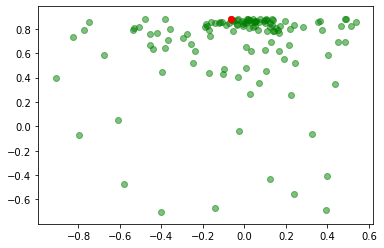

In [512]:
predicted_x = []
predicted_y = []
true_x = []
true_y = []
curr = X[0].reshape(1,-1).numpy()

for sample, next in zip(X, y):
    pred = reg.predict(curr)
    predicted_x.append(curr[:,1])
    predicted_y.append(curr[:,2])
    true_x.append(sample[1].numpy().item())
    true_y.append(sample[2].numpy().item())
    curr = pred.reshape(1,-1)

start_point = true_x[0], true_y[0]

# plt.scatter(predicted_x, predicted_y, alpha=0.5)
plt.scatter(true_x, true_y, c="g", alpha=0.5)
plt.scatter(start_point[0], start_point[1], c='r')

plt.show()



In [513]:
trainer = Trainer(batch_size=128, epochs=10)
tr_losses, val_losses = trainer.train(tr, dev)

Epoch 0 training MSE: 0.0041687400080263615
Epoch 0 validation MSE: 0.0023299682447138954
Epoch 1 training MSE: 0.0019546833354979753
Epoch 1 validation MSE: 0.001820419994957231
Epoch 2 training MSE: 0.0017594764940440655
Epoch 2 validation MSE: 0.0017788520187394467
Epoch 3 training MSE: 0.0017432314343750477
Epoch 3 validation MSE: 0.001776094813170059
Epoch 4 training MSE: 0.001742023741826415
Epoch 4 validation MSE: 0.0017759611797060742
Epoch 5 training MSE: 0.0017419892828911543
Epoch 5 validation MSE: 0.0017759889660943595
Epoch 6 training MSE: 0.0017420370131731033
Epoch 6 validation MSE: 0.0017760144061344672
Epoch 7 training MSE: 0.001742073567584157
Epoch 7 validation MSE: 0.0017760288043656676
Epoch 8 training MSE: 0.0017420949880033731
Epoch 8 validation MSE: 0.0017760360999453215
Epoch 9 training MSE: 0.0017421073280274868
Epoch 9 validation MSE: 0.001776039631780747


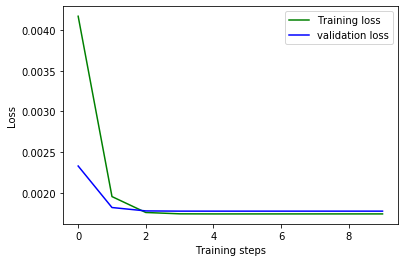

In [514]:
import matplotlib.pyplot as plt
timestamps = np.arange(0,10)
plt.plot(timestamps, tr_losses, 'g', label='Training loss')
plt.plot(timestamps, val_losses, 'b', label='validation loss')
plt.xlabel('Training steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [515]:
trainer.predict(episode_data=test[2])

KeyError: 0

In [ ]:
# 50 episodes, each having various num of timestamps
episode_data = test[0]
X, y = zip(*
            [(r['observation'], r['next_observation']) for r in episode_data if r['next_observation'] != None]
        )
X = torch.tensor(X)
y = torch.tensor(y)        
X, y = normalize(X, y)
        
state_ids = [1,2]
    
results = []
curr_state = X[0]

for true_state, true_next_state in zip(X,y):
    next_states = trainer.model(curr_state)
    predictions = next_states[state_ids]

    results.append([curr_state[state_ids], true_state[state_ids]])
    curr_state = next_states.detach()


results[0]

In [ ]:
num_timestamps = 500

predicted_x = [r[0][0].numpy() for r in results[:num_timestamps]]
predicted_Y = [r[0][1].numpy() for r in results[:num_timestamps]]

true_x = [r[1][0].numpy() for r in results[:num_timestamps]]
true_y = [r[1][1].numpy() for r in results[:num_timestamps]]



In [ ]:
print(predicted_x[0], predicted_Y[0])
print(true_x[0], true_y[0])

In [ ]:
start_point = predicted_x[0], predicted_Y[0]
start_point

ValueError: x and y must be the same size

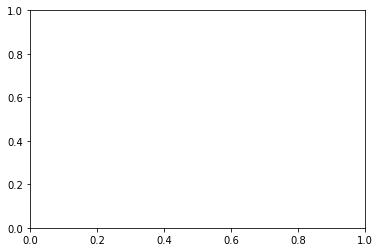

In [516]:
plt.scatter(predicted_x, predicted_Y, alpha=0.5)
plt.scatter(true_x, true_y, c="g", alpha=0.5, s=3)
plt.scatter(start_point[0], start_point[1], c='r')

plt.plot(predicted_x, predicted_Y, alpha=0.8)
plt.plot(true_x, true_y, c="g", alpha=0.5)
plt.scatter(start_point[0], start_point[1], c='r')

plt.show()


